# <center> Train LSTM with word2vec embeddings </center>

https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings and https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [20]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import roc_curve, auc
from capstone_project import preprocessor as pre
from capstone_project.models import neural_nets

%matplotlib inline

Set some necessary constants:

In [2]:
MAX_SEQUENCE_LENGTH = 50 # Maximum length of input for lstm the maximum number of tokens is 103 
EMBEDDING_DIM = 300  # Length of the used word2vec implementation

In [3]:
file_directory = "../output/data/"
prefix = "tokenized_"

train_data = pre.load_pickle(file_directory, prefix+"train_data.pkl")
val_data = pre.load_pickle(file_directory, prefix+"val_data.pkl")  # Validation data set used to compare different classification algorithms
train_y = train_data["is_duplicate"].values
val_y = val_data["is_duplicate"].values


train_data =  train_data[:100]
train_y = train_y[:100]
val_data =  val_data[:100]
val_y = val_y[:100]

Prepare the tokenized question as input for keras:

In [4]:
# Decode again and join strings because keras tokenizer crashes when using unicode while spacy uses it
q1_tokens = train_data["q1_tokens"].apply(lambda x: unidecode(" ".join(x))).values
q2_tokens = train_data["q2_tokens"].apply(lambda x: unidecode(" ".join(x))).values
all_tokens = np.concatenate([q1_tokens, q2_tokens])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tokens)

word_index = tokenizer.word_index
number_words = len(word_index)+1  # Needed for embedding layer
print("Found {} unique tokens".format(len(word_index)))

q1_sequences = tokenizer.texts_to_sequences(q1_tokens)
q2_sequences = tokenizer.texts_to_sequences(q2_tokens)


q1_data = pad_sequences(q1_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(q2_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 617 unique tokens


split second val and train set for validation at every epoch:

In [32]:
# split the data into a training set and a second validation set see: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
indices = np.arange(q1_data.shape[0])
np.random.shuffle(indices)
q1_data = q1_data[indices]
q2_data = q2_data[indices]
labels = train_y[indices]

nb_validation_samples = int(0.1 * q1_data.shape[0])

q1_train = q1_data[:-nb_validation_samples]
q2_train = q1_data[:-nb_validation_samples]
train_labels = labels[:-nb_validation_samples]

# Mirror question in order to avoid symmetry issues
q12_train = np.concatenate((q1_train, q2_train), axis=0)
q21_train = np.concatenate((q2_train, q1_train), axis=0)
double_train_labels = np.concatenate((train_labels, train_labels), axis=0)

#create validation set that is used to validate each epoch during training
q1_val_epochs = q1_data[-nb_validation_samples:]
q2_val_epochs = q2_data[-nb_validation_samples:]
val_epochs_labels = labels[-nb_validation_samples:]

# Mirror val questions in order to avoid symmetry issues
q12_val_epochs = np.concatenate((q1_val_epochs, q2_val_epochs), axis=0)
q21_val_epochs = np.concatenate((q2_val_epochs, q1_val_epochs), axis=0)
double_val_epochs_labels = np.concatenate((val_epochs_labels, val_epochs_labels), axis=0)

#create correct emebeddings for validation data
q1_val_tokens = val_data["q1_tokens"].apply(lambda x: unidecode(" ".join(x))).values
q2_val_tokens = val_data["q2_tokens"].apply(lambda x: unidecode(" ".join(x))).values

q1_val_sequences = tokenizer.texts_to_sequences(q1_val_tokens)
q2_val_sequences = tokenizer.texts_to_sequences(q2_val_tokens)

q1_val_data = pad_sequences(q1_val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_val_data = pad_sequences(q2_val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_labels = val_y

#join validation and train data in order to train on the complete dataset
q1_all_data = np.concatenate((q1_data, q1_val_data), axis=0)
q2_all_data = np.concatenate((q2_data, q2_val_data), axis=0)
all_labels = np.concatenate((labels, val_labels), axis=0)

# Mirror question in order to avoid symmetry issues
q12_all = np.concatenate((q1_all_data, q2_all_data), axis=0)
q21_all = np.concatenate((q2_all_data, q1_all_data), axis=0)
double_all_labels = np.concatenate((all_labels, all_labels), axis=0)

Load the pretrained word2vec model:

In [7]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [8]:
nn_parameters = {"max_sequence_length": MAX_SEQUENCE_LENGTH,
                 "num_lstm": 200,
                 "dropout_lstm": 0.25,
                 "num_dense": 100,
                 "dropout_dense": 0.25}

stamp = "{}_{:2f}_{}_{:.2f}".format(nn_parameters["num_lstm"], 
                                    nn_parameters["dropout_lstm"],
                                    nn_parameters["num_dense"],
                                    nn_parameters["dropout_dense"])

embedding_matrix = neural_nets.create_embedding_matrix(word2vec_model, EMBEDDING_DIM, word_index, number_words)
model = neural_nets.create_lstm(embedding_matrix, EMBEDDING_DIM, number_words, **nn_parameters)

Null word embeddings: 50


 fit the train data with early stopping:

In [9]:
# See https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
model.summary()
print stamp

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
best_model_path = "../output/models/lstm_val_epochs_" + stamp + '.h5'
model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([q12_train, q21_train], double_train_labels,
                 validation_data=([q12_val_epochs, q21_val_epochs], double_val_epochs_labels), 
                 epochs=200, batch_size=8, shuffle=True,
                 callbacks=[early_stopping, model_checkpoint]) #batch_size = 2048

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 50)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 50, 300)       185400      input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 200)           400800      embedding_1[0][0]       

In [10]:
model_path = "../output/models/lstm_" + stamp + '.h5'
model.fit([q1_data, q2_data], train_y, epochs=3, batch_size=8, shuffle=True,) #batch_size = 2048
model.save(model_path)

Epoch 1/3
100/100 [==============================] - 1s - loss: 1.7506 - acc: 0.5600     
Epoch 2/3
100/100 [==============================] - 1s - loss: 0.7406 - acc: 0.7000     
Epoch 3/3
100/100 [==============================] - 1s - loss: 0.5438 - acc: 0.7300     


In [15]:
model = load_model(model_path)

predictions = model.predict([q1_val_data, q2_val_data], batch_size=8, verbose=1) # batch_size=8192
predictions += model.predict([q2_val_data, q1_val_data], batch_size=8, verbose=1)
predictions /= 2

loss = log_loss(val_y, predictions)
acc = accuracy_score(val_y, np.rint(predictions))

print "Validation scores of Lstm model\n LogLoss: {:.4f}\n Accuracy: {:.2f} ".format(loss, acc)


100/100 [==============================] - 0s     
Validation scores of Lstm model
 LogLoss: 0.9066
 Accuracy: 0.49 


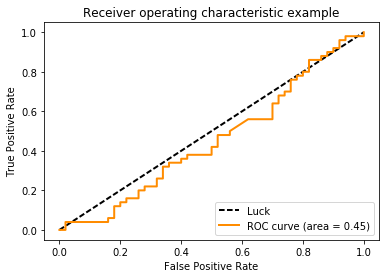

In [38]:
fpr, tpr, thresholds = roc_curve(val_y, predictions)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig("../output/figures/lstm_roc_plot.png")
plt.show()


In [34]:
model_path = "../output/models/full_final_lstm_" + stamp + '.h5'
model.fit([q12_all, q21_all], double_all_labels, epochs=3, batch_size=8, shuffle=True,) #batch_size = 2048
model.save(model_path)

Epoch 1/3
400/400 [==============================] - 5s - loss: 0.8077 - acc: 0.5750     
Epoch 2/3
400/400 [==============================] - 5s - loss: 0.7206 - acc: 0.6025     
Epoch 3/3
400/400 [==============================] - 5s - loss: 0.6049 - acc: 0.6800     
